In [1]:
import os
import random
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.callbacks import ModelCheckpoint
import random

# Transformer block
def transformer_block(inputs, num_heads, dff, rate=0.2):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=dff)(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Create Transformer model
def create_transformer_model(num_time_slices, d_model, num_heads, dff, do_rate):
    inputs = Input(shape=(num_time_slices, d_model))
    x = transformer_block(inputs, num_heads, dff, rate=do_rate)
    outputs = Dense(1)(x[:, 0, :])  # Linear activation for regression
    return Model(inputs=inputs, outputs=outputs)

def load_data(file_path):
    data = scipy.io.loadmat(file_path)
    return data['spectrogram'], data['timestamps'][0]

def generate_sequences_and_labels(spectrogram, timestamps, sequence_length, start_index):
    end_index = start_index + sequence_length
    sequence = spectrogram[:, start_index:end_index]
    # Calculate time to failure for the start of the sequence
    time_to_failure = timestamps[-1] - timestamps[start_index]
    # Normalize sequence
    sequence_normalized = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))
    sequence_transposed = np.transpose(sequence_normalized)
    return sequence_transposed, time_to_failure

def train_test_split(spectrogram, train_size=0.8):
    train_end = int(spectrogram.shape[1] * train_size)
    train_data = spectrogram[:, :train_end]
    test_data = spectrogram[:, train_end:]
    return train_data, test_data


In [4]:
def downsample_spectrogram(spectrogram, num_bins=None, factor=0.1):
    """
    Downsamples the spectrogram by averaging over 'factor' adjacent frequency bins.
    
    Args:
    spectrogram (numpy.ndarray): The original spectrogram.
    factor (int): The factor by which to downsample the spectrogram.
    
    Returns:
    numpy.ndarray: The downsampled spectrogram.
    """
    # The number of rows (frequency bins) after downsampling
    if num_bins = None:
        new_num_bins = spectrogram.shape[0] // factor
    else:
        new_num_bins = num_bins
        factor = spectrogram.shape[0]/new_num_bins
    
    # Initialize the downsampled spectrogram
    downsampled = np.zeros((new_num_bins, spectrogram.shape[1]))

    for i in range(new_num_bins):
        start_index = i * factor
        end_index = start_index + factor
        downsampled[i, :] = np.mean(spectrogram[start_index:end_index, :], axis=0)

    return downsampled


In [8]:

from datetime import datetime

def convert_timestamps_to_seconds(timestamps):
    """Convert string timestamps to seconds."""
    datetime_format = "%Y.%m.%d.%H.%M.%S"
    datetime_objects = [datetime.strptime(ts, datetime_format) for ts in timestamps]
    reference_time = datetime_objects[0]
    return [(dt - reference_time).total_seconds() for dt in datetime_objects]

def normalize_labels(labels):
    """Normalize labels to a range between 0 and 1."""
    max_val = max(labels)
    min_val = min(labels)
    return [(label - min_val) / (max_val - min_val) for label in labels]

from datetime import datetime, timezone

def convert_unix_timestamps_to_seconds(timestamps):
    """Convert Unix timestamps to seconds since the first timestamp."""
    datetime_objects = [datetime.fromtimestamp(float(ts), tz=timezone.utc) for ts in timestamps]
    reference_time = datetime_objects[0]
    return [(dt - reference_time).total_seconds() for dt in datetime_objects]

def load_data_and_process_labels(file_path):
    """Load data and process labels."""
    data = scipy.io.loadmat(file_path)
    spectrogram = data['spectrogram']

    # Extract timestamps and convert them to seconds
    timestamps = data['timestamps']
    if isinstance(timestamps, np.ndarray):
        timestamps = timestamps.flatten()
    else:
        raise ValueError("Timestamps format not recognized")

    time_to_failure_seconds = convert_unix_timestamps_to_seconds(timestamps)
    normalized_labels = normalize_labels(time_to_failure_seconds)
    return spectrogram, normalized_labels


In [4]:

# Define paths
data_folder = r"C:\Users\simon\signal_analysis\vibration_anal\vibration_analysis_nov\data\IMS\processed\sep_spec"  # Replace with your data folder path
mat_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.mat')]

In [12]:
from tqdm.notebook import tqdm

# Define model parameters
num_heads = 8
num_features = 256

learning_rate = 0.0001
batch_size = 32
do_rate = 0.6

checkpoint_filepath = r'model/model_checkpoint.keras'
checkpoint_callback = ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=True,
monitor='val_loss',
mode='min',
save_best_only=True)

# Define paths
# data_folder = r"data/"  # Replace with your data folder path
# mat_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.mat')]
# random.shuffle(mat_files)

# Load one file to get the number of frequency bins
spectrogram, _ = load_data(mat_files[0])
# num_frequency_bins = int(spectrogram.shape[0]/10)
dff = num_features
num_frequency_bins = num_features

num_features = num_frequency_bins

initial_sequence_length = 100  # Start with a smaller sequence length
max_sequence_length = spectrogram.shape[1]  # Full length of your time slices
# print("max_sequence_length:")
# print(max_sequence_length)

# Initialize the model
model = create_transformer_model(initial_sequence_length, num_frequency_bins, num_heads, dff, do_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define training parameters
num_epochs = 50
sequence_length_increment = 50  # How much to increment the sequence length
# increment_interval = 2  # How many epochs to complete before incrementing sequence length
# train_val_split_ratio = 0.8  # Ratio to split training and validation sequences
num_validation_sequences_per_file = 50  # Number of validation sequences to take from each file

# Determine the shortest sequence in all files
min_file_length = min([load_data(file)[0].shape[1] for file in mat_files])

# Calculate the maximum sequence length
max_sequence_length = min_file_length - initial_sequence_length

# Define the maximum number of increments possible
max_increments = (max_sequence_length - initial_sequence_length) // sequence_length_increment


# Training and validation loop
current_seq_length = initial_sequence_length

avg_losses = []



epoch_prog_bar = tqdm(range(num_epochs), desc='Training', leave=True)
for epoch in epoch_prog_bar:
    # print(f"Epoch {epoch+1}/{num_epochs}")
    # Shuffle files for each epoch
    np.random.shuffle(mat_files)
    
    increment = min(epoch, max_increments)
    current_seq_length = initial_sequence_length + increment * sequence_length_increment

    # Training
    train_progress_bar = tqdm(mat_files[:-1], desc=f'Epoch {epoch+1}', leave=False)
    for file_path in train_progress_bar:
        # print(file_path)
        spectrogram, normalized_labels = load_data_and_process_labels(file_path)
        # spectrogram = downsample_spectrogram(spectrogram, 10)
        spectrogram = downsample_spectrogram(spectrogram, num_features)
        num_sequences = spectrogram.shape[1] - current_seq_length

        for _ in tqdm(range(num_sequences // batch_size), desc='Batches', leave=False):
            start_index = np.random.randint(0, num_sequences)
            end_index = start_index + current_seq_length
            sequence = spectrogram[:, start_index:end_index]
            sequence_normalized = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))
            sequence_transposed = np.transpose(sequence_normalized, axes=(1, 0))
            label = normalized_labels[end_index - 1]  # Get the corresponding normalized label

            # Expand dimensions to match input shape for the model
            sequence = np.expand_dims(sequence_transposed, axis=0)  # Add batch dimension
            label = np.array([[label]])  # Match the expected model output shape

            # Train the model on the sequence
            model.train_on_batch(sequence, label)

    # Validation
    val_progress_bar = tqdm(mat_files[-1:], desc='Validation', leave=False)
    validation_loss = []
    for file_path in val_progress_bar:
        spectrogram, normalized_labels = load_data_and_process_labels(file_path)
        # spectrogram = downsample_spectrogram(spectrogram, 10)
        spectrogram = downsample_spectrogram(spectrogram, num_features)
        # time_to_failure_seconds = convert_timestamps_to_seconds(timestamps)
        # normalized_labels = normalize_labels(time_to_failure_seconds)

        num_sequences = spectrogram.shape[1] - current_seq_length

        if num_sequences > 0:
            valid_sequences = min(num_validation_sequences_per_file, num_sequences)

            if valid_sequences > 0:
                validation_indices = np.random.choice(num_sequences, valid_sequences, replace=False)

                val_file_prog_bar = tqdm(validation_indices, desc='Val_file', leave=False)
                for val_index in val_file_prog_bar:
                    start_index = np.random.randint(0, num_sequences)
                    end_index = start_index + current_seq_length
                    sequence = spectrogram[:, start_index:end_index]
                    sequence_normalized = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))
                    sequence_transposed = np.transpose(sequence_normalized, axes=(1, 0))
                    label = normalized_labels[end_index - 1]  # Get the corresponding normalized label

                    # Expand dimensions to match input shape for the model
                    sequence = np.expand_dims(sequence_transposed, axis=0)  # Add batch dimension
                    label = np.array([[label]])  # Match the expected model output shape

                    # Evaluate the model on the validation sequence
                    val_loss = model.evaluate(sequence, label, verbose=0)
                    validation_loss.append(val_loss)
        else:
            print(f"No valid sequences for validation in file: {file_path}")

    if len(validation_loss) == 0:
        print(f"Validation failed on epoch {epoch}")
        continue
    # Compute average validation loss for the epoch
    avg_val_loss = np.mean(validation_loss)
    avg_losses.append(avg_val_loss)
    # print(f"Validation loss for epoch {epoch+1}: {avg_val_loss}")
    
    epoch_prog_bar.desc = f"Training - Previous loss: {avg_val_loss}"

    # Save model at the end of each epoch
    model.save('model/model_epoch_{:04d}.keras'.format(epoch+1))

    # Save model if it has the best validation loss
    if epoch == 0 or avg_val_loss < min(validation_loss):
        model.save(checkpoint_filepath)
print(avg_losses)


max_sequence_length:
2156
Epoch 1/5


Training:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\simon\signal_analysis\vibration_anal\vibration_analysis_nov\data\IMS\processed\sep_spec\2_channel_0.mat


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Continue from last epoch:

In [ ]:
epoch_prog_bar = tqdm(range(epoch, num_epochs), desc='Training', leave=True)
for epoch in epoch_prog_bar:
    # print(f"Epoch {epoch+1}/{num_epochs}")
    # Shuffle files for each epoch
    np.random.shuffle(mat_files)
    
    current_seq_length = initial_sequence_length + epoch*sequence_length_increment

    # Training
    train_progress_bar = tqdm(mat_files, desc=f'Epoch {epoch+1}', leave=False)
    for file_path in train_progress_bar:
        # print(file_path)
        spectrogram, normalized_labels = load_data_and_process_labels(file_path)
        # spectrogram = downsample_spectrogram(spectrogram, 10)
        spectrogram = downsample_spectrogram(spectrogram, num_features)
        num_sequences = spectrogram.shape[1] - current_seq_length

        for _ in tqdm(range(num_sequences // batch_size), desc='Batches', leave=False):
            start_index = np.random.randint(0, num_sequences)
            end_index = start_index + current_seq_length
            sequence = spectrogram[:, start_index:end_index]
            sequence_normalized = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))
            sequence_transposed = np.transpose(sequence_normalized, axes=(1, 0))
            label = normalized_labels[end_index - 1]  # Get the corresponding normalized label

            # Expand dimensions to match input shape for the model
            sequence = np.expand_dims(sequence_transposed, axis=0)  # Add batch dimension
            label = np.array([[label]])  # Match the expected model output shape

            # Train the model on the sequence
            model.train_on_batch(sequence, label)

    # Validation
    val_progress_bar = tqdm(mat_files, desc='Validation', leave=False)
    validation_loss = []
    for file_path in val_progress_bar:
        spectrogram, normalized_labels = load_data_and_process_labels(file_path)
        # spectrogram = downsample_spectrogram(spectrogram, 10)
        spectrogram = downsample_spectrogram(spectrogram, num_features)
        # time_to_failure_seconds = convert_timestamps_to_seconds(timestamps)
        # normalized_labels = normalize_labels(time_to_failure_seconds)

        num_sequences = spectrogram.shape[1] - current_seq_length

        valid_sequences = min(num_validation_sequences_per_file, num_sequences)

        if valid_sequences > 0:
            validation_indices = np.random.choice(num_sequences, valid_sequences, replace=False)

            val_file_prog_bar = tqdm(validation_indices, desc='Val_file', leave=False)
            for val_index in val_file_prog_bar:
                start_index = np.random.randint(0, num_sequences)
                end_index = start_index + current_seq_length
                sequence = spectrogram[:, start_index:end_index]
                sequence_normalized = (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))
                sequence_transposed = np.transpose(sequence_normalized, axes=(1, 0))
                label = normalized_labels[end_index - 1]  # Get the corresponding normalized label

                # Expand dimensions to match input shape for the model
                sequence = np.expand_dims(sequence_transposed, axis=0)  # Add batch dimension
                label = np.array([[label]])  # Match the expected model output shape

                # Evaluate the model on the validation sequence
                val_loss = model.evaluate(sequence, label, verbose=0)
                validation_loss.append(val_loss)

    # Compute average validation loss for the epoch
    avg_val_loss = np.mean(validation_loss)
    avg_losses.append(avg_val_loss)
    # print(f"Validation loss for epoch {epoch+1}: {avg_val_loss}")
    
    epoch_prog_bar.desc = f"Training - Previous loss: {avg_val_loss}"

    # Save model at the end of each epoch
    model.save('model/model_epoch_{:04d}.h5'.format(epoch+1))

    # Save model if it has the best validation loss
    if epoch == 0 or avg_val_loss < min(validation_loss):
        model.save(checkpoint_filepath)
print(avg_losses)


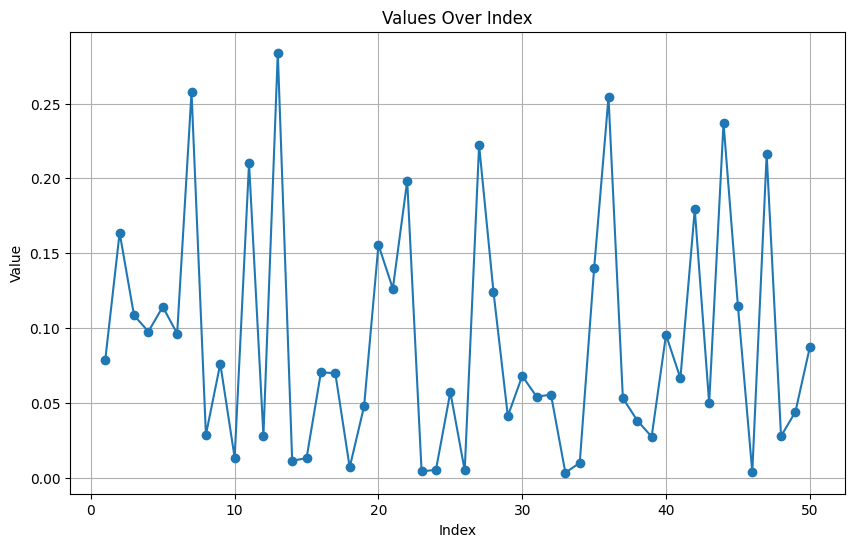

In [5]:
import matplotlib.pyplot as plt

# Your array
values = [0.07870380120439222, 0.16370724393542332, 0.10851530223037116, 0.09766204715240746, 0.1142032180453549, 0.09629575579005177, 0.25766145581379535, 0.02871163902542321, 0.07616529458345667, 0.013354693306609988, 0.21018647395074366, 0.02802917436696589, 0.28395434260368346, 0.0113463055761531, 0.013121634877752513, 0.07044020141591317, 0.06984294278707238, 0.006912924091084278, 0.04769353044808163, 0.15558846190571785, 0.12635277040302753, 0.1983710317313671, 0.004235039808554575, 0.005306457812021108, 0.05720058210194111, 0.004842164450983546, 0.222158355563879, 0.12419863104820252, 0.04127260042761918, 0.06800549339128338, 0.05417685141786933, 0.05551442541182041, 0.003356556369463597, 0.009944503655742737, 0.13980214014649392, 0.2543374541401863, 0.05316606619984668, 0.038236095507018036, 0.027422541330233797, 0.09544723789440468, 0.06650074782199226, 0.1792832738161087, 0.04978771944530308, 0.23703636184334756, 0.11480289734899998, 0.0037572820414871443, 0.21614596992731094, 0.027798010536171206, 0.04406094655394554, 0.08714798197150231]

# Create the x-axis as 1-based index
x_axis = range(1, len(values) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_axis, values, marker='o')
plt.title("Values Over Index")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

